# Probability Evolution Over Time

This notebook analyzes how probability estimates from LLMs evolve over time by varying the knowledge cutoff date. This allows us to:

1. **Track forecast accuracy** - See how forecasts improve as more information becomes available
2. **Measure calibration** - Compare forecasts to actual outcomes at different time horizons
3. **Identify information shocks** - Detect when major news events shifted predictions
4. **Visualize uncertainty** - Show how forecast confidence changes over time

**Example Use Case:** Analyze how an LLM's forecast for "Will Trump win the 2024 election?" evolved from January 2024 to Election Day (November 5, 2024).

In [1]:
import sys
sys.path.append('..')
import os
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
from datetime import datetime
from ipywidgets import interact, IntSlider
from probability_estimator import get_probability_distribution_over_time, analyze_probability_evolution
import asyncio

# Check for OpenRouter API key
openrouter_available = os.environ.get("OPENROUTER_API_KEY") is not None

print(f"OpenRouter API Key available: {openrouter_available}")
if not openrouter_available:
    print("\nWarning: Set OPENROUTER_API_KEY environment variable to run this notebook.")

OpenRouter API Key available: True


## Configuration

Set your forecasting question and time range here:

In [17]:
# Forecasting question
# FORECAST_QUESTION = "Will Donald Trump win the 2024 US Presidential election?"
FORECAST_QUESTION = "Will Lee Jae-myung be elected the next president of South Korea?"

# Time range for analysis
START_DATE = datetime(2024, 1, 1)
END_DATE = datetime(2024, 11, 5)  # Election day
FREQUENCY_DAYS = 30  # Sample every 30 days (monthly)

START_DATE = datetime(2025, 4, 1)
END_DATE = datetime(2025, 6, 3)  # Election day
FREQUENCY_DAYS = 5  # Sample every 30 days (monthly)




# Number of samples per time point
N_SAMPLES = 1

# Model to use
MODEL = "openai/gpt-4o-mini"
MODEL =  "openai/gpt-5"

# Actual outcome (for comparison)
# Set to 1.0 if the event happened, 0.0 if it didn't, or None if unknown
ACTUAL_OUTCOME = 1.0  # Trump won the 2024 election

print(f"Question: {FORECAST_QUESTION}")
print(f"Time range: {START_DATE.strftime('%B %d, %Y')} to {END_DATE.strftime('%B %d, %Y')}")
print(f"Frequency: Every {FREQUENCY_DAYS} days")
print(f"Samples per time point: {N_SAMPLES}")
print(f"Model: {MODEL}")
if ACTUAL_OUTCOME is not None:
    print(f"Actual outcome: {ACTUAL_OUTCOME:.0%}")

Question: Will Lee Jae-myung be elected the next president of South Korea?
Time range: April 01, 2025 to June 03, 2025
Frequency: Every 5 days
Samples per time point: 1
Model: openai/gpt-5
Actual outcome: 100%


## Collect Probability Distributions Over Time

This cell queries the LLM with different knowledge cutoff dates to see how the probability estimate evolved.

**Note:** This may take several minutes depending on the number of time points and samples.

In [18]:
if openrouter_available:
    print("Collecting probability distributions over time...")
    print(f"This will query the API at {FREQUENCY_DAYS}-day intervals from {START_DATE.strftime('%B %Y')} to {END_DATE.strftime('%B %Y')}")
    print()
    
    evolution_results = await get_probability_distribution_over_time(
        prompt=FORECAST_QUESTION,
        start_date=START_DATE,
        end_date=END_DATE,
        frequency_days=FREQUENCY_DAYS,
        n_samples=N_SAMPLES,
        model=MODEL
    )
    
    print(f"\n✓ Collected data for {len(evolution_results)} time points")
    print("Ready for visualization!")
else:
    print("Cannot collect data: OpenRouter API key not set.")
    evolution_results = None

This will query the API at 5-day intervals from April 2025 to June 2025

Querying probability distributions over time:
  Start: 2025-04-01
  End: 2025-06-03
  Frequency: 5 days
  Total queries: 14

[1/14] Querying with knowledge cutoff: April 01, 2025
  Mean probability: 0.350 (±0.000)

[2/14] Querying with knowledge cutoff: April 06, 2025
  Mean probability: 0.380 (±0.000)

[3/14] Querying with knowledge cutoff: April 11, 2025
  Mean probability: 0.300 (±0.000)

[4/14] Querying with knowledge cutoff: April 16, 2025
  Mean probability: 0.300 (±0.000)

[5/14] Querying with knowledge cutoff: April 21, 2025
  Mean probability: 0.350 (±0.000)

[6/14] Querying with knowledge cutoff: April 26, 2025
  Mean probability: 0.400 (±0.000)

[7/14] Querying with knowledge cutoff: May 01, 2025
  Mean probability: 0.400 (±0.000)

[8/14] Querying with knowledge cutoff: May 06, 2025
  Mean probability: 0.340 (±0.000)

[9/14] Querying with knowledge cutoff: May 11, 2025
  Mean probability: 0.350 (±0.000)

## Interactive Distribution Explorer

Use the slider below to explore how the probability distribution evolved at each time point.

**Features:**
- **Histogram**: Shows the distribution of probability estimates from 10 samples
- **Mean Line** (red dashed): Average probability estimate
- **Median Line** (green dotted): Median probability estimate
- **Actual Outcome** (gold solid): The true outcome (if known)
- **Statistics Box**: Mean, std dev, min, max, and range

In [19]:
if evolution_results:
    # Prepare data for visualization
    sorted_dates = sorted(evolution_results.keys())
    date_objects = [datetime.strptime(d, '%Y-%m-%d') for d in sorted_dates]
    
    def create_evolution_plot(date_index):
        """Create histogram for a specific date index with detailed statistics."""
        date_str = sorted_dates[date_index]
        date_obj = date_objects[date_index]
        dist = evolution_results[date_str]
        
        probs = np.array(dist['probabilities'])
        mean_val = probs.mean()
        std_val = probs.std()
        median_val = np.median(probs)
        
        # Create histogram
        fig = go.Figure()
        
        # Add histogram
        fig.add_trace(go.Histogram(
            x=probs,
            nbinsx=20,
            marker_color='steelblue',
            marker_line_color='white',
            marker_line_width=1.5,
            opacity=0.85,
            hovertemplate='Probability: %{x:.2%}<br>Count: %{y}<extra></extra>',
            name='Distribution'
        ))
        
        # Add mean line
        fig.add_vline(
            x=mean_val,
            line_dash="dash",
            line_color="red",
            line_width=3,
            annotation_text=f"Mean: {mean_val:.1%}",
            annotation_position="top right",
            annotation_font_size=16,
            annotation_font_color="red"
        )
        
        # Add median line
        fig.add_vline(
            x=median_val,
            line_dash="dot",
            line_color="darkgreen",
            line_width=2,
            annotation_text=f"Median: {median_val:.1%}",
            annotation_position="bottom right",
            annotation_font_size=16,
            annotation_font_color="darkgreen"
        )
        
        # Add actual outcome line if available
        if ACTUAL_OUTCOME is not None:
            outcome_text = f"Actual: {ACTUAL_OUTCOME:.0%}"
            if ACTUAL_OUTCOME == 1.0:
                outcome_text += " (Event Occurred)"
            elif ACTUAL_OUTCOME == 0.0:
                outcome_text += " (Event Did Not Occur)"
            
            fig.add_vline(
                x=ACTUAL_OUTCOME,
                line_dash="solid",
                line_color="gold",
                line_width=3,
                annotation_text=outcome_text,
                annotation_position="top left",
                annotation_font_size=16,
                annotation_font_color="gold"
            )
        
        # Calculate forecast error
        if ACTUAL_OUTCOME is not None:
            forecast_error = abs(mean_val - ACTUAL_OUTCOME)
            error_text = f"Forecast Error: {forecast_error:.1%} | Std Dev: {std_val:.1%}"
        else:
            error_text = f"Std Dev: {std_val:.1%}"
        
        # Update layout
        fig.update_layout(
            title=dict(
                text=f"<b>Probability Distribution</b><br>" +
                     f"<sub>Knowledge Cutoff: {dist['knowledge_cutoff_date']}</sub><br>" +
                     f"<sub>{error_text}</sub>",
                font=dict(size=22),
                x=0.5,
                xanchor='center'
            ),
            xaxis=dict(
                title="Probability Estimate",
                title_font_size=18,
                tickfont_size=16,
                range=[0, 1],
                tickformat='.0%'
            ),
            yaxis=dict(
                title=f"Count (out of {N_SAMPLES} samples)",
                title_font_size=18,
                tickfont_size=16
            ),
            height=800,
            width=1400,
            showlegend=False,
            font=dict(size=16),
            plot_bgcolor='rgba(240,240,240,0.5)',
            margin=dict(t=120, b=80, l=80, r=80)
        )
        
        # Add statistics annotation
        stats_text = (
            f"<b>Statistics (n={N_SAMPLES}):</b><br>" +
            f"Mean: {mean_val:.1%}<br>" +
            f"Std Dev: {std_val:.1%}<br>" +
            f"Min: {probs.min():.1%}<br>" +
            f"Max: {probs.max():.1%}<br>" +
            f"Range: {probs.max() - probs.min():.1%}"
        )
        
        fig.add_annotation(
            text=stats_text,
            xref="paper", yref="paper",
            x=0.02, y=0.98,
            xanchor='left', yanchor='top',
            showarrow=False,
            font=dict(size=14),
            bgcolor='rgba(255,255,255,0.9)',
            bordercolor='black',
            borderwidth=2,
            borderpad=10
        )
        
        fig.show()
    
    # Create interactive slider
    date_labels = [f"{d.strftime('%B %d, %Y')}" for d in date_objects]
    
    print("Use the slider below to explore how the probability distribution evolved over time:")
    print()
    
    interact(
        create_evolution_plot,
        date_index=IntSlider(
            min=0,
            max=len(sorted_dates)-1,
            step=1,
            value=0,
            description='Date:',
            style={'description_width': '60px'},
            layout={'width': '800px'},
            continuous_update=False
        )
    )
    
    print(f"\nDate range: {date_objects[0].strftime('%B %d, %Y')} to {date_objects[-1].strftime('%B %d, %Y')}")
    print(f"Total time points: {len(sorted_dates)}")
else:
    print("No evolution data to visualize. Run the data collection cell above first.")

Use the slider below to explore how the probability distribution evolved over time:



interactive(children=(IntSlider(value=0, continuous_update=False, description='Date:', layout=Layout(width='80…


Date range: April 01, 2025 to June 03, 2025
Total time points: 14


## Forecast Evolution Timeline

This plot shows how the mean probability estimate evolved over time, with error bars showing ±1 standard deviation at each time point.

**Key Features:**
- **Blue line**: Mean probability estimate over time
- **Error bars**: ±1 standard deviation (showing uncertainty)
- **Shaded region**: Confidence band (±1 std dev)
- **Gold line**: Actual outcome (if known)
- **Summary statistics**: Initial vs final forecast, error improvement

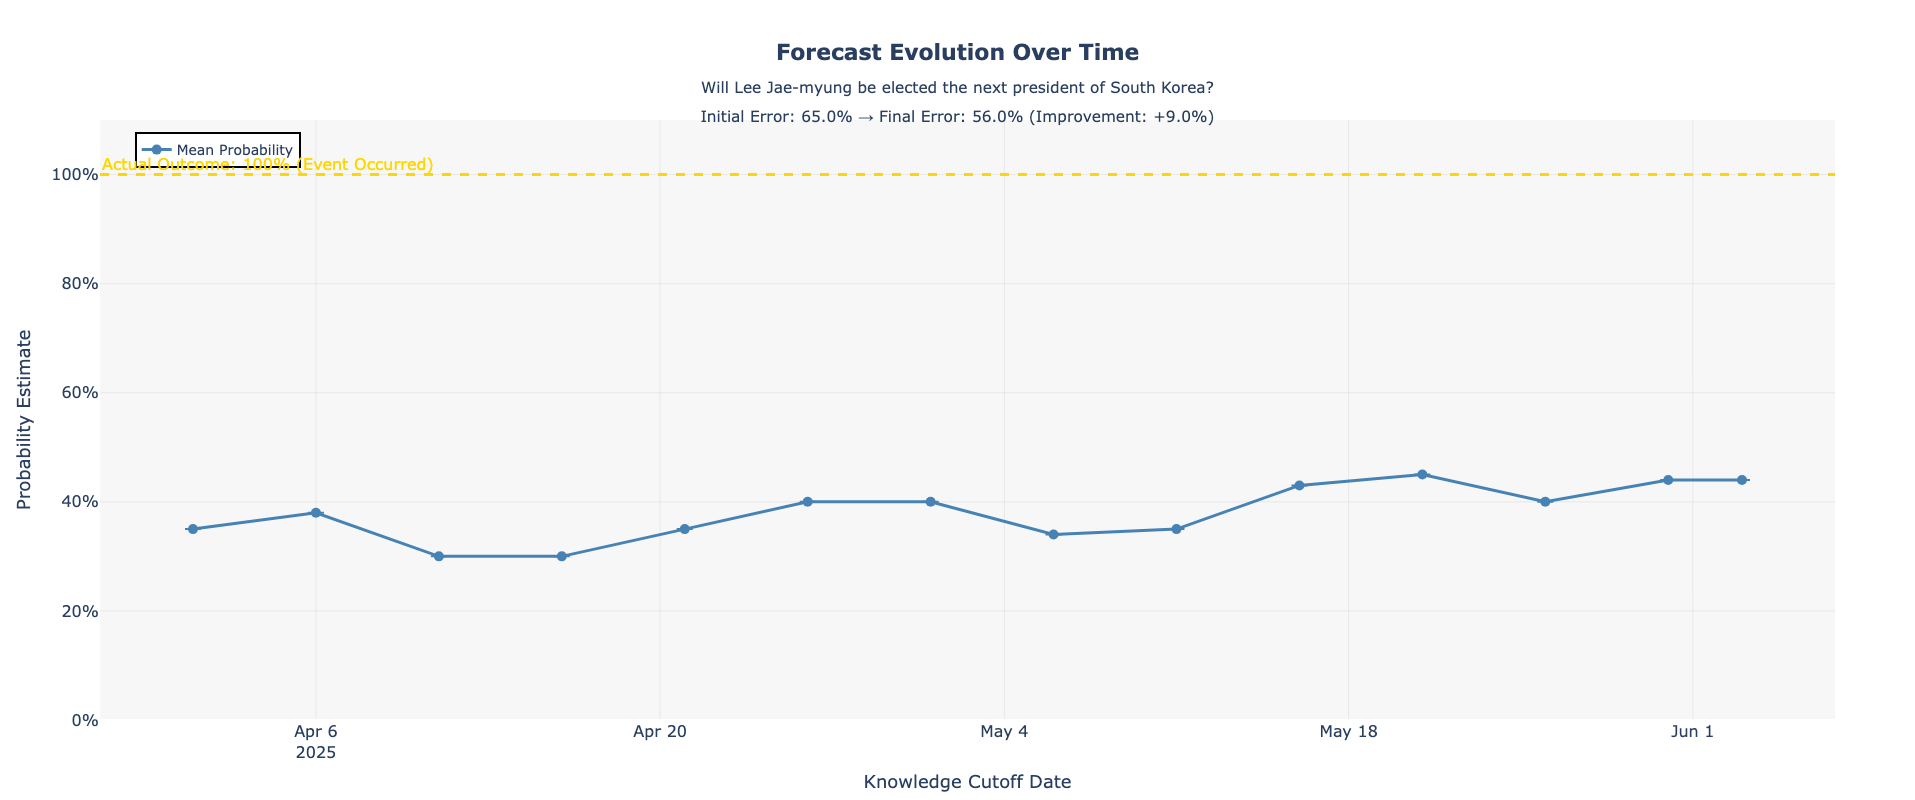

In [20]:
if evolution_results:
    # Analyze the evolution
    stats_df = await analyze_probability_evolution(evolution_results)
    
    # Create figure
    fig = go.Figure()
    
    # Add mean line with error bars
    fig.add_trace(go.Scatter(
        x=stats_df['date'],
        y=stats_df['mean'],
        mode='lines+markers',
        name='Mean Probability',
        line=dict(color='steelblue', width=3),
        marker=dict(size=10, color='steelblue', symbol='circle'),
        error_y=dict(
            type='data',
            array=stats_df['std'],
            visible=True,
            color='steelblue',
            thickness=2,
            width=8
        ),
        hovertemplate='<b>%{x|%B %d, %Y}</b><br>Mean: %{y:.1%}<extra></extra>'
    ))
    
    # Add actual outcome line if available
    if ACTUAL_OUTCOME is not None:
        outcome_text = f"Actual Outcome: {ACTUAL_OUTCOME:.0%}"
        if ACTUAL_OUTCOME == 1.0:
            outcome_text += " (Event Occurred)"
        elif ACTUAL_OUTCOME == 0.0:
            outcome_text += " (Event Did Not Occur)"
        
        fig.add_hline(
            y=ACTUAL_OUTCOME,
            line_dash="dash",
            line_color="gold",
            line_width=3,
            annotation_text=outcome_text,
            annotation_position="top left",
            annotation_font_size=16,
            annotation_font_color="gold"
        )
    
    # Add shaded confidence band (±1 std dev)
    fig.add_trace(go.Scatter(
        x=stats_df['date'],
        y=stats_df['mean'] + stats_df['std'],
        mode='lines',
        line=dict(width=0),
        showlegend=False,
        hoverinfo='skip'
    ))
    
    fig.add_trace(go.Scatter(
        x=stats_df['date'],
        y=stats_df['mean'] - stats_df['std'],
        mode='lines',
        line=dict(width=0),
        fillcolor='rgba(70, 130, 180, 0.2)',
        fill='tonexty',
        showlegend=False,
        hoverinfo='skip',
        name='±1 Std Dev'
    ))
    
    # Calculate initial and final forecast errors
    title_text = f"<b>Forecast Evolution Over Time</b><br><sub>{FORECAST_QUESTION}</sub>"
    
    if ACTUAL_OUTCOME is not None:
        initial_error = abs(stats_df.iloc[0]['mean'] - ACTUAL_OUTCOME)
        final_error = abs(stats_df.iloc[-1]['mean'] - ACTUAL_OUTCOME)
        improvement = initial_error - final_error
        
        title_text += (
            f"<br><sub>Initial Error: {initial_error:.1%} → Final Error: {final_error:.1%} " +
            f"(Improvement: {improvement:+.1%})</sub>"
        )
    
    # Update layout
    fig.update_layout(
        title=dict(
            text=title_text,
            font=dict(size=22),
            x=0.5,
            xanchor='center'
        ),
        xaxis=dict(
            title="Knowledge Cutoff Date",
            title_font_size=18,
            tickfont_size=16,
            showgrid=True,
            gridwidth=1,
            gridcolor='rgba(200,200,200,0.3)'
        ),
        yaxis=dict(
            title="Probability Estimate",
            title_font_size=18,
            tickfont_size=16,
            range=[0, 1.1],
            tickformat='.0%',
            showgrid=True,
            gridwidth=1,
            gridcolor='rgba(200,200,200,0.3)'
        ),
        height=800,
        width=1400,
        font=dict(size=16),
        plot_bgcolor='rgba(240,240,240,0.5)',
        margin=dict(t=120, b=80, l=100, r=80),
        hovermode='x unified',
        legend=dict(
            x=0.02,
            y=0.98,
            xanchor='left',
            yanchor='top',
            bgcolor='rgba(255,255,255,0.9)',
            bordercolor='black',
            borderwidth=2,
            font=dict(size=14)
        )
    )
    
    fig.show()
else:
    print("No evolution data to visualize. Run the data collection cell above first.")

## Summary Statistics

Detailed statistics about the forecast evolution:

In [21]:
if evolution_results:
    print("="*80)
    print("FORECAST EVOLUTION SUMMARY")
    print("="*80)
    print(f"\nQuestion: {FORECAST_QUESTION}")
    print(f"Model: {evolution_results[sorted_dates[0]]['model']}")
    print(f"Samples per time point: {N_SAMPLES}")
    print(f"Time range: {stats_df.iloc[0]['date'].strftime('%B %d, %Y')} to {stats_df.iloc[-1]['date'].strftime('%B %d, %Y')}")
    print(f"Number of time points: {len(stats_df)}")
    
    print(f"\nInitial forecast ({stats_df.iloc[0]['date'].strftime('%B %d, %Y')}): {stats_df.iloc[0]['mean']:.1%} ± {stats_df.iloc[0]['std']:.1%}")
    print(f"Final forecast ({stats_df.iloc[-1]['date'].strftime('%B %d, %Y')}): {stats_df.iloc[-1]['mean']:.1%} ± {stats_df.iloc[-1]['std']:.1%}")
    
    if ACTUAL_OUTCOME is not None:
        print(f"Actual outcome: {ACTUAL_OUTCOME:.0%}")
        
        initial_error = abs(stats_df.iloc[0]['mean'] - ACTUAL_OUTCOME)
        final_error = abs(stats_df.iloc[-1]['mean'] - ACTUAL_OUTCOME)
        improvement = initial_error - final_error
        
        print(f"\nForecast error improvement: {improvement:+.1%}")
        
        if stats_df.iloc[-1]['mean'] > ACTUAL_OUTCOME:
            print(f"Final forecast overestimated by {abs(stats_df.iloc[-1]['mean'] - ACTUAL_OUTCOME):.1%}")
        else:
            print(f"Final forecast underestimated by {abs(stats_df.iloc[-1]['mean'] - ACTUAL_OUTCOME):.1%}")
        
        # Find best and worst forecasts
        best_idx = (stats_df['mean'] - ACTUAL_OUTCOME).abs().idxmin()
        worst_idx = (stats_df['mean'] - ACTUAL_OUTCOME).abs().idxmax()
        
        print(f"\nBest forecast: {stats_df.iloc[best_idx]['date'].strftime('%B %d, %Y')} - {stats_df.iloc[best_idx]['mean']:.1%} (error: {abs(stats_df.iloc[best_idx]['mean'] - ACTUAL_OUTCOME):.1%})")
        print(f"Worst forecast: {stats_df.iloc[worst_idx]['date'].strftime('%B %d, %Y')} - {stats_df.iloc[worst_idx]['mean']:.1%} (error: {abs(stats_df.iloc[worst_idx]['mean'] - ACTUAL_OUTCOME):.1%})")
    
    print("\n" + "="*80)
    
    # Display full dataframe
    print("\nDetailed Statistics by Time Point:")
    print("="*80)
    display_df = stats_df.copy()
    display_df['date'] = display_df['date'].dt.strftime('%B %d, %Y')
    display_df['mean'] = display_df['mean'].apply(lambda x: f"{x:.1%}")
    display_df['std'] = display_df['std'].apply(lambda x: f"{x:.1%}")
    display_df['min'] = display_df['min'].apply(lambda x: f"{x:.1%}")
    display_df['max'] = display_df['max'].apply(lambda x: f"{x:.1%}")
    
    if ACTUAL_OUTCOME is not None:
        display_df['error'] = (stats_df['mean'] - ACTUAL_OUTCOME).abs().apply(lambda x: f"{x:.1%}")
    
    print(display_df.to_string(index=False))
else:
    print("No evolution data available. Run the data collection cell above first.")

FORECAST EVOLUTION SUMMARY

Question: Will Lee Jae-myung be elected the next president of South Korea?
Model: openai/gpt-5
Samples per time point: 1
Time range: April 01, 2025 to June 03, 2025
Number of time points: 14

Initial forecast (April 01, 2025): 35.0% ± 0.0%
Final forecast (June 03, 2025): 44.0% ± 0.0%
Actual outcome: 100%

Forecast error improvement: +9.0%
Final forecast underestimated by 56.0%

Best forecast: May 21, 2025 - 45.0% (error: 55.0%)
Worst forecast: April 11, 2025 - 30.0% (error: 70.0%)


Detailed Statistics by Time Point:
          date  mean  median  std   min   max  q25  q75  n_samples        model knowledge_cutoff_date error
April 01, 2025 35.0%    0.35 0.0% 35.0% 35.0% 0.35 0.35          1 openai/gpt-5        April 01, 2025 65.0%
April 06, 2025 38.0%    0.38 0.0% 38.0% 38.0% 0.38 0.38          1 openai/gpt-5        April 06, 2025 62.0%
April 11, 2025 30.0%    0.30 0.0% 30.0% 30.0% 0.30 0.30          1 openai/gpt-5        April 11, 2025 70.0%
April 16, 2025 30

## Key Insights

**What This Analysis Shows:**

1. **Forecast Improvement**: How much did forecasts improve as more information became available? Look at the difference between initial and final forecast errors.

2. **Uncertainty Over Time**: The error bars (±1 standard deviation) show the range of estimates. Narrower bars indicate more consistent forecasts, suggesting either:
   - Greater confidence in the prediction
   - More deterministic responses from the model

3. **Calibration Analysis**: By comparing forecasts to the actual outcome, we can measure forecast accuracy at different time horizons. This helps us understand:
   - How far in advance can the model make accurate predictions?
   - Does the model systematically over/underestimate certain types of events?

4. **Information Shocks**: Large changes between consecutive time points may indicate major news events that shifted predictions. Look for:
   - Sudden jumps in the mean probability
   - Changes in the standard deviation (uncertainty)

**Limitations:**

- This analysis assumes the model's knowledge cutoff feature works perfectly
- Sample size is limited (10 samples per time point by default)
- The model may have access to information about the event even with restricted knowledge cutoffs
- Results may vary significantly with different prompt wordings